# Continuous Control

---

In this notebook, we'll solve the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment

#import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time
from itertools import count
%matplotlib inline

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux_NoVis_20/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment (not applicable on AWS).  

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
tic = time.time()
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
toc=time.time()
print('Total score (averaged over agents) this episode: {}, episode time: {}'.format(np.mean(scores), toc-tic))

### 4. Training time, let's get down to business

Now it's time to solve the environment. I have the goals of both minimum episodes to solve the environment, and achieving maximum average score. As seen below, the trained agent is able to solve the task in less then 140 episodes, and best average score of above 37. Done!

The hyperparameters used appear in 'ddpg_agent.py', and the final hyperparameters are also copied below:
```
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 20       # timesteps between updates
NUM_UPDATES = 10        # num of update passes when updating
EPSILON = 1.0           # Epsilon for the noise process added to the actions
EPSILON_DECAY = 1e-6    # Decay for epsilon above
NOISE_SIGMA = 0.05      # sigma for Ornstein-Uhlenbeck noise
```


Episode 1, Average Score: 0.29, Max Score: 0.75, Min Score: 0.00, Time per Episode: 9.70
Episode 2, Average Score: 0.51, Max Score: 1.52, Min Score: 0.00, Time per Episode: 9.93
Episode 3, Average Score: 0.56, Max Score: 1.27, Min Score: 0.08, Time per Episode: 9.98
Episode 4, Average Score: 0.68, Max Score: 2.04, Min Score: 0.33, Time per Episode: 10.07
Episode 5, Average Score: 0.71, Max Score: 1.93, Min Score: 0.22, Time per Episode: 10.16
Episode 6, Average Score: 0.78, Max Score: 2.12, Min Score: 0.03, Time per Episode: 10.25
Episode 7, Average Score: 0.90, Max Score: 3.04, Min Score: 0.69, Time per Episode: 10.33
Episode 8, Average Score: 0.94, Max Score: 2.87, Min Score: 0.22, Time per Episode: 10.42
Episode 9, Average Score: 0.98, Max Score: 3.09, Min Score: 0.22, Time per Episode: 10.48
Episode 10, Average Score: 1.00, Max Score: 2.26, Min Score: 0.12, Time per Episode: 10.62
Episode 10	Average Score: 1.00
Episode 11, Average Score: 1.01, Max Score: 4.73, Min Score: 0.20, Time

Episode 94, Average Score: 18.27, Max Score: 39.57, Min Score: 37.47, Time per Episode: 19.24
Episode 95, Average Score: 18.49, Max Score: 39.58, Min Score: 36.09, Time per Episode: 19.38
Episode 96, Average Score: 18.68, Max Score: 39.62, Min Score: 28.80, Time per Episode: 19.20
Episode 97, Average Score: 18.88, Max Score: 39.67, Min Score: 30.73, Time per Episode: 19.25
Episode 98, Average Score: 19.09, Max Score: 39.64, Min Score: 37.73, Time per Episode: 19.21
Episode 99, Average Score: 19.28, Max Score: 39.49, Min Score: 36.15, Time per Episode: 19.24
Episode 100, Average Score: 19.47, Max Score: 39.62, Min Score: 34.40, Time per Episode: 19.27
Episode 100	Average Score: 19.47
Episode 101, Average Score: 19.86, Max Score: 39.62, Min Score: 33.74, Time per Episode: 19.14
Episode 106, Average Score: 21.73, Max Score: 39.57, Min Score: 28.33, Time per Episode: 19.11
Episode 107, Average Score: 22.09, Max Score: 39.62, Min Score: 34.33, Time per Episode: 19.19
Episode 108, Average Sc

Episode 175, Average Score: 37.28, Max Score: 39.57, Min Score: 31.76, Time per Episode: 18.55

Environment best average (above 37.0) in 175 episodes!	Average Score: 37.28
Episode 176, Average Score: 37.32, Max Score: 39.66, Min Score: 38.27, Time per Episode: 18.63

Environment best average (above 37.0) in 176 episodes!	Average Score: 37.32
Episode 177, Average Score: 37.37, Max Score: 39.65, Min Score: 29.21, Time per Episode: 18.58

Environment best average (above 37.0) in 177 episodes!	Average Score: 37.37
Episode 178, Average Score: 37.39, Max Score: 39.23, Min Score: 33.10, Time per Episode: 18.52

Environment best average (above 37.0) in 178 episodes!	Average Score: 37.39
Episode 179, Average Score: 37.42, Max Score: 39.67, Min Score: 26.49, Time per Episode: 18.62

Environment best average (above 37.0) in 179 episodes!	Average Score: 37.42
Episode 180, Average Score: 37.42, Max Score: 39.61, Min Score: 26.49, Time per Episode: 18.66
Episode 180	Average Score: 37.42
Episode 181,

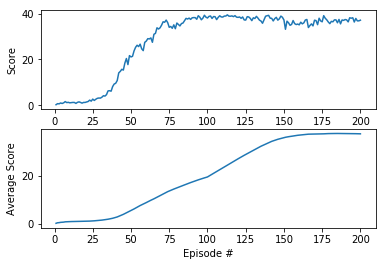

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=15)
avg_over = 100
print_every = 10

def ddpg(n_episodes=200):
    scores_deque = deque(maxlen=avg_over)
    scores_global = []
    average_global = []
    best_avg = -np.inf
    solved = False
    tic = time.time()
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        
        score_average = 0
        timestep = time.time()
        for t in count():
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states                               # roll over states to next time step
            scores += rewards                                  # update the score (for each agent)            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        score = np.mean(scores)
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        average_global.append(score_average)
                
        print('\rEpisode {}, Average Score: {:.2f}, Max Score: {:.2f}, Min Score: {:.2f}, Time per Episode: {:.2f}'\
              .format(i_episode, score_average, np.max(scores), np.min(scores), time.time() - timestep), end="\n")        
        
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
            
        if score_average >= 30.0:
            if not solved:
                toc = time.time()
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}, training time: {}'.format(i_episode, score_average, toc-tic))
                solved = True
                torch.save(agent.actor_local.state_dict(), 'best_checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'best_checkpoint_critic.pth')
        if score_average >=37.0 and score_average > best_avg: 
            best_avg = score_average
            print('\nEnvironment best average (above 37.0) in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, score_average)) 
            
    return scores_global, average_global

scores, averages = ddpg()

fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

plt.subplot(2, 1, 2)
plt.plot(np.arange(1, len(scores)+1), averages)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()


### 5. Test a smart agent

In [6]:
agent.actor_local.load_state_dict(torch.load('best_checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('best_checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 37.03649917216971


When finished, you can close the environment.

In [ ]:
env.close()